In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Introduction
This project uses the SPY ETF, which tracks the S&P 500, the main stock market index in the United States. It also uses the ASHR ETF, which tracks the CSI 300, the primary index in China. The objective is to compare the two markets and identify potential correlations. For forecasting with ARIMA, only SPY ETF will be used. For forecasting with GARCH, both will be use to provide hedging opportunities if they have one.

# Data Cleaning & Preprocessing
Check for NaN values, datetime object, different operating hours and normalizing to compare returns.

In [4]:
# Download the Data from Yahoo! Finance

def download(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    return df

start_date = "2023-01-01"
end_date = "2025-04-16"

us = download("SPY", start_date, end_date)
china = download("ASHR", start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Handles Missing Values

In [6]:
# Check Datetime object -> easier to work with time series analysis
print(f"US Data type: {us.index.dtype}")
print(f"China Data type: {china.index.dtype}")

mv = us.isnull().Close.sum()
mv2 = china.isnull().Close.sum()
print(f"NaN data: {mv.SPY}")
print(f"NaN data: {mv2.ASHR}")
# 0 means there's no missing Data. if there're missing values, use dropna(), fillna() or interpoalte() depend on the data.

US Data type: datetime64[ns]
China Data type: datetime64[ns]
NaN data: 0
NaN data: 0


#### Resampling the Data
The US (SPY) might have different trading days compared to China (ASHR). This can be checked by comparing datetime objects.

In [8]:
print(f"Do US and China ETF data have the same index?: {us.index.equals(china.index)}")

Do US and China ETF data have the same index?: True


#### Normalizing the Data
Since the price range for the SPY ETF is 523.91 to 531.16, and for the ASHR ETF is 25.48 to 25.65, normalization is necessary for a clearer visual comparison.

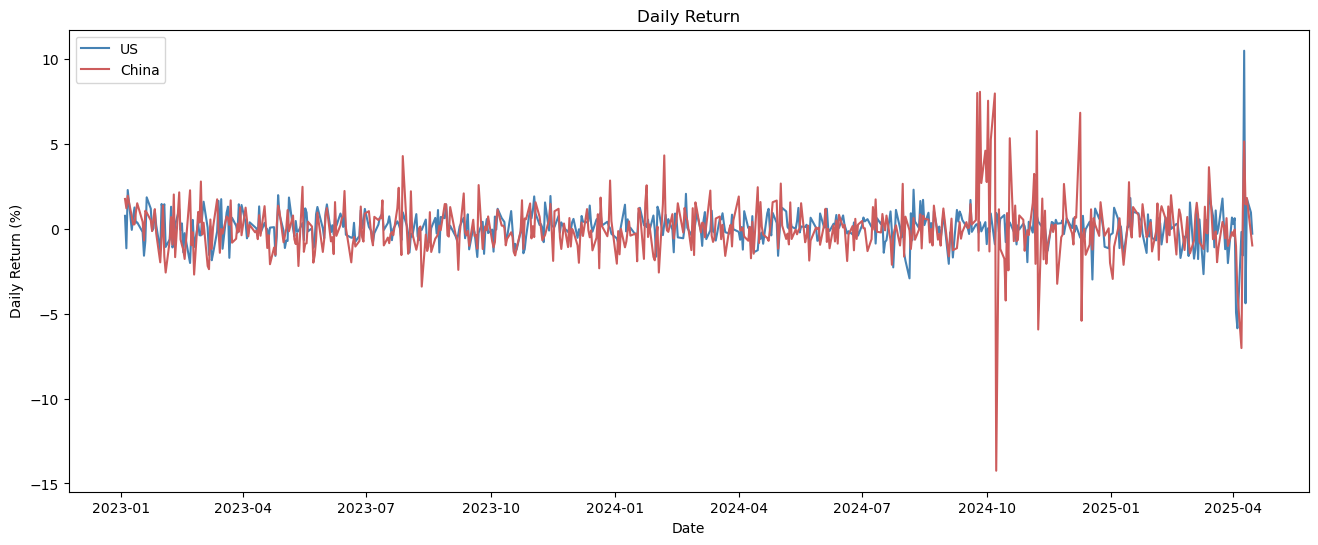

In [10]:
us["daily_return"] = us["Close"].pct_change() * 100
us.dropna(inplace=True) # drop first NaN
china["daily_return"] = china["Close"].pct_change() * 100
china.dropna(inplace=True) # drop first NaN

plt.figure(figsize=(16,6))
plt.title("Daily Return")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.plot(us["daily_return"], color="steelblue", label="US")
plt.plot(china["daily_return"], color="indianred", label="China")
plt.legend()


# The plot shows that China's market is more volatile than the US.
# Clearly, there's seem to be period of much higher volatilty than others --> GARCH can be implement
# I picked GARCH instead of ARCH because since there's much more persistant volatility than just a "Bursty" type volatility 

# Exploratory Data Analysis
The data is split into a 95:5 train-test ratio to improve forecast accuracy. Since an ARIMA model will be used, it is essential to ensure that the data is stationary. In this section, the mean and variance are visualized, and a log-differencing method is applied to achieve stationarity. Furthermore, the Augmented Dickey-Fuller (ADF) test is conducted to test stationarity.

In [12]:
# Split Data into train and test 
us_train = us.iloc[:int(len(us)*0.95)].copy()
us_test = us.iloc[int(len(us)*0.95):].copy()

china_train = china.iloc[:int(len(us)*0.95)].copy()
china_test = china.iloc[int(len(us)*0.95):].copy()

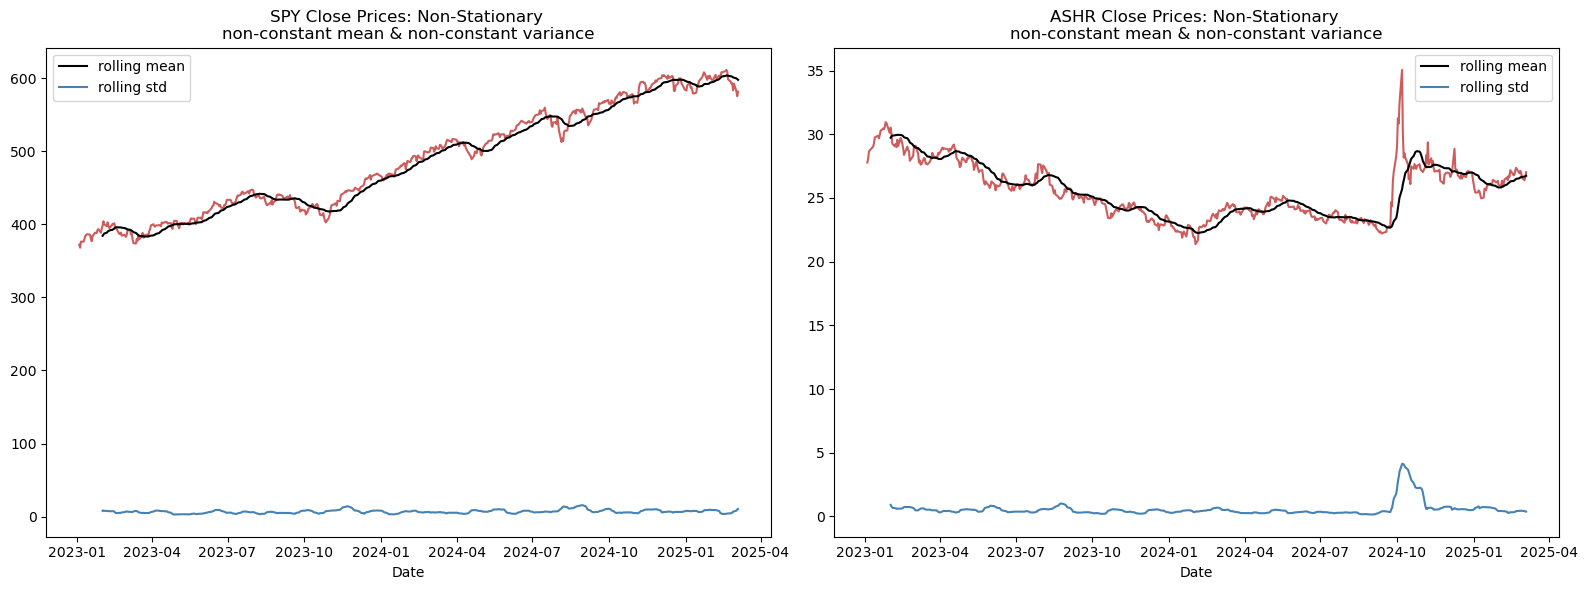

In [13]:
# Visualize check: mean and variance
rolling_window = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# SPY plot
axes[0].set_title("SPY Close Prices: Non-Stationary \nnon-constant mean & non-constant variance")
axes[0].set_xlabel("Date")
axes[0].plot(us_train.Close, color='indianred')
axes[0].plot(us_train.Close.rolling(rolling_window).mean(), color='black', label='rolling mean')
axes[0].plot(us_train.Close.rolling(rolling_window).std(), color='steelblue', label='rolling std')
axes[0].legend()

# ASHR plot
axes[1].set_title("ASHR Close Prices: Non-Stationary \nnon-constant mean & non-constant variance")
axes[1].set_xlabel("Date")
axes[1].plot(china_train.Close, color='indianred')
axes[1].plot(china_train.Close.rolling(rolling_window).mean(), color='black', label='rolling mean')
axes[1].plot(china_train.Close.rolling(rolling_window).std(), color='steelblue', label='rolling std')
axes[1].legend()

plt.tight_layout()
plt.show()

# As seen in the plot, the mean for both datasets is not constant. And China's rolling std has a little kink during the last quarter of 2024
# Due to investors pessimistic about China's economy and its tech sector after Xi Jin Ping annoucement about the tech industry back in 2024.

#### Augmented Dickey–Fuller test
If the ADF statistic is below the critical value, the data can be considered stationary with the corresponding level of confidence.

In [15]:
def adf_test(df):
    test_result = adfuller(df)
    print(f"ADF Statistics: {test_result[0]}")
    print(f"P-Values: {test_result[1]}")
    print("Critical Values:")
    for thres, adf_stat in test_result[4].items():
        print(f"{thres}: {adf_stat}")

adf_test(us_train["Close"])
# In this case, the p-value is higher than the significance level of 0.1 (10%), 
# failing to reject the null hypothesis and the conclusion that the series is non-stationary (US). The same goes with China

ADF Statistics: -0.9361255349289886
P-Values: 0.7758431502433465
Critical Values:
1%: -3.442472769145813
5%: -2.8668873212324817
10%: -2.5696179384812297


#### Log-Difference Transformation
Transformations such as logarithms can help to stabilise the variance of a time series. Differencing is required to achieve stationarity by stabilizing the mean. This process has been applied to both the US and China ETFs, and the resulting transformations are presented in the plots below. Note: I tried using the Box-Cox transformation, but it made the data "too stationary" and less useful for visualizing or forecasting ETF prices. So, I switched to log-differencing instead.

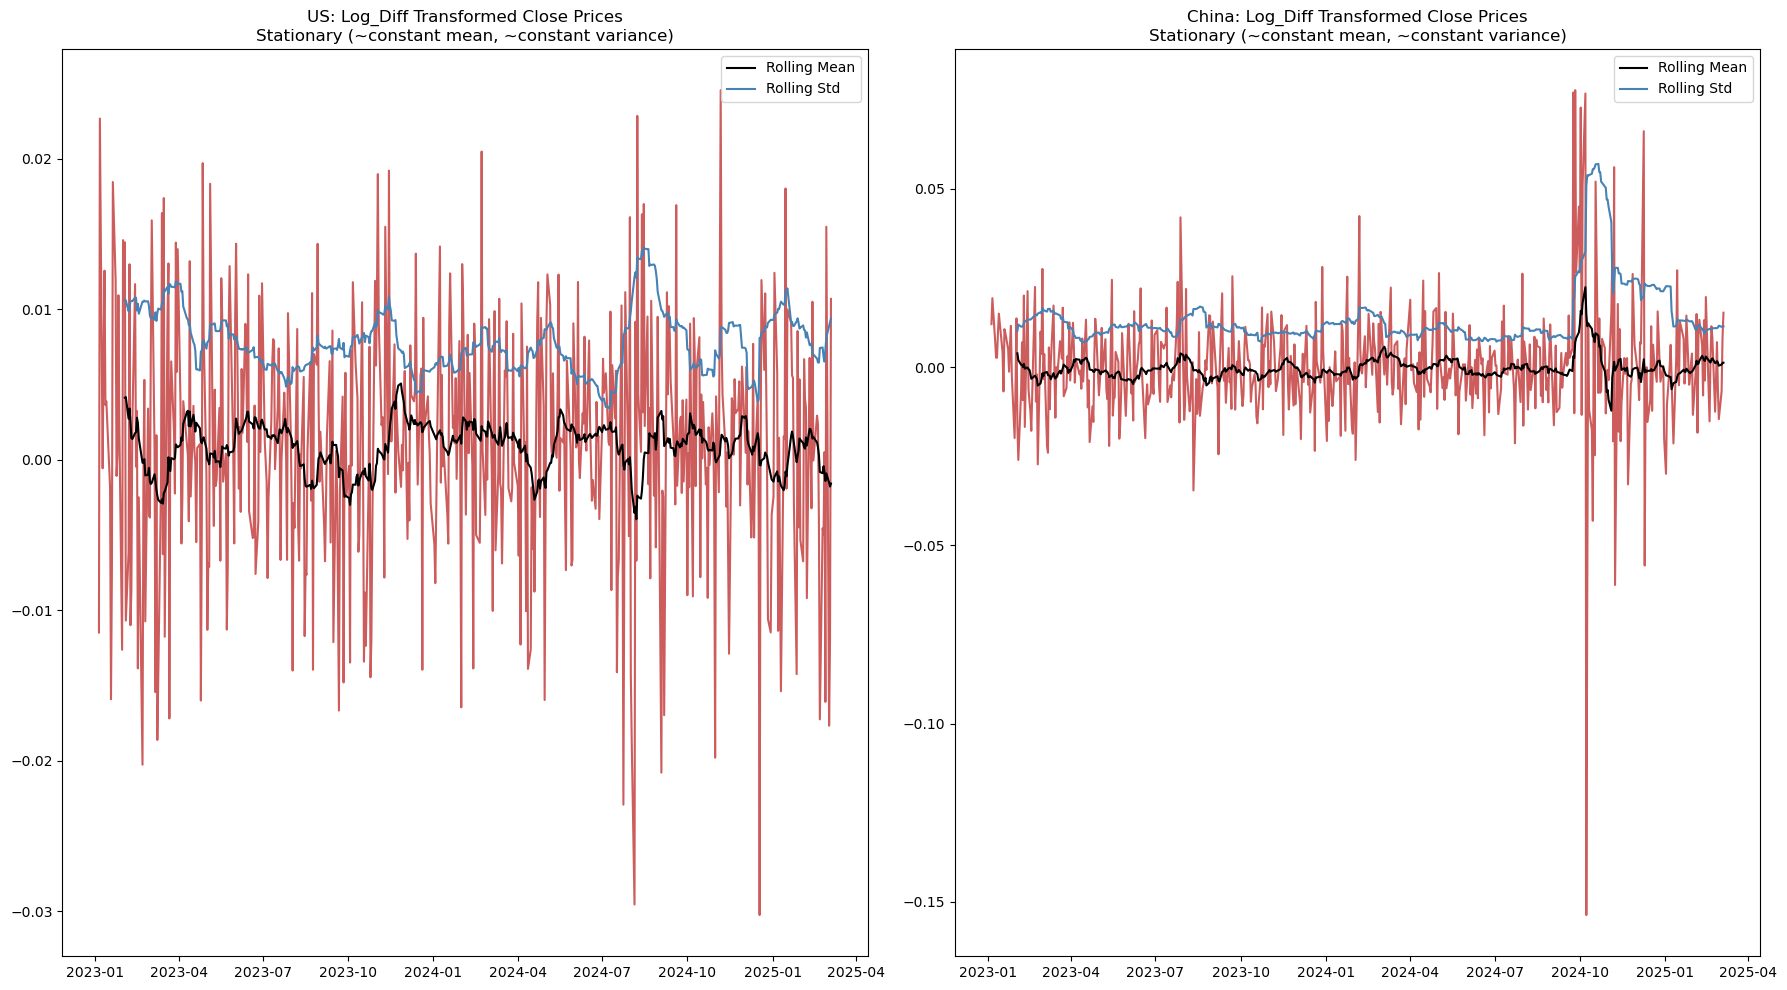

In [17]:
# Log-Difference Transformation
us_train["Close_log"] = np.log(us_train["Close"])
us_train["Close_log_diff"] = us_train["Close_log"].diff()
us_train.dropna(inplace=True) # Drop first NaN

# Also try it with China
china_train["Close_log"] = np.log(china_train["Close"])
china_train["Close_log_diff"] = china_train["Close_log"].diff()
china_train.dropna(inplace=True) # Drop first NaN

# For later graphing purpose 
us_test["Close_log"] = np.log(us_test["Close"])

fig, axes = plt.subplots(1, 2, figsize=(18, 10), dpi=100)

# US 
axes[0].plot(us_train["Close_log_diff"], color="indianred")
axes[0].plot(us_train["Close_log_diff"].rolling(rolling_window).mean(), color='black', label='Rolling Mean')
axes[0].plot(us_train["Close_log_diff"].rolling(rolling_window).std(), color='steelblue', label='Rolling Std')
axes[0].set_title('US: Log_Diff Transformed Close Prices\nStationary (~constant mean, ~constant variance)')
axes[0].legend()

# China 
axes[1].plot(china_train["Close_log_diff"], color="indianred")
axes[1].plot(china_train["Close_log_diff"].rolling(rolling_window).mean(), color='black', label='Rolling Mean')
axes[1].plot(china_train["Close_log_diff"].rolling(rolling_window).std(), color='steelblue', label='Rolling Std')
axes[1].set_title('China: Log_Diff Transformed Close Prices\nStationary (~constant mean, ~constant variance)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Now, let's check the ADF test again
print("US:")
adf_test(us_train["Close_log_diff"])
print("\n")
print("China:")
adf_test(china_train["Close_log_diff"])

# Now the p-values ~ 0 -> reject the hypothesis and conclude that the data is stationary

US:
ADF Statistics: -22.614767151603417
P-Values: 0.0
Critical Values:
1%: -3.442495284887805
5%: -2.86689723299801
10%: -2.5696232204003677


China:
ADF Statistics: -7.635933638060391
P-Values: 1.9524938740350505e-11
Critical Values:
1%: -3.442819521824351
5%: -2.8670399588708047
10%: -2.5696992792614384


#### Autocorrelation & Partial Autocorrelation
Since ARIMA = AR + I + MA (Autoregressive + Integrated + Moving Average): AR represents a forecasting model that uses a linear combination of previous values. We need to determine how many past (lagged) values are used. I represents the number of differencing operations required to make the time series stationary. MA represents a moving average that uses past forecast errors instead of the actual previous values. We also need to determine how many past forecast errors are used.

The autoregressive and moving average lagged value can be found by analyzing the partial autocorrelation function (PACF) and the autocorrelation function (ACF), respectively. The idea behind this is to plot a correlogram of the various lags or forecast errors of the time series to determine which are statistically significant.

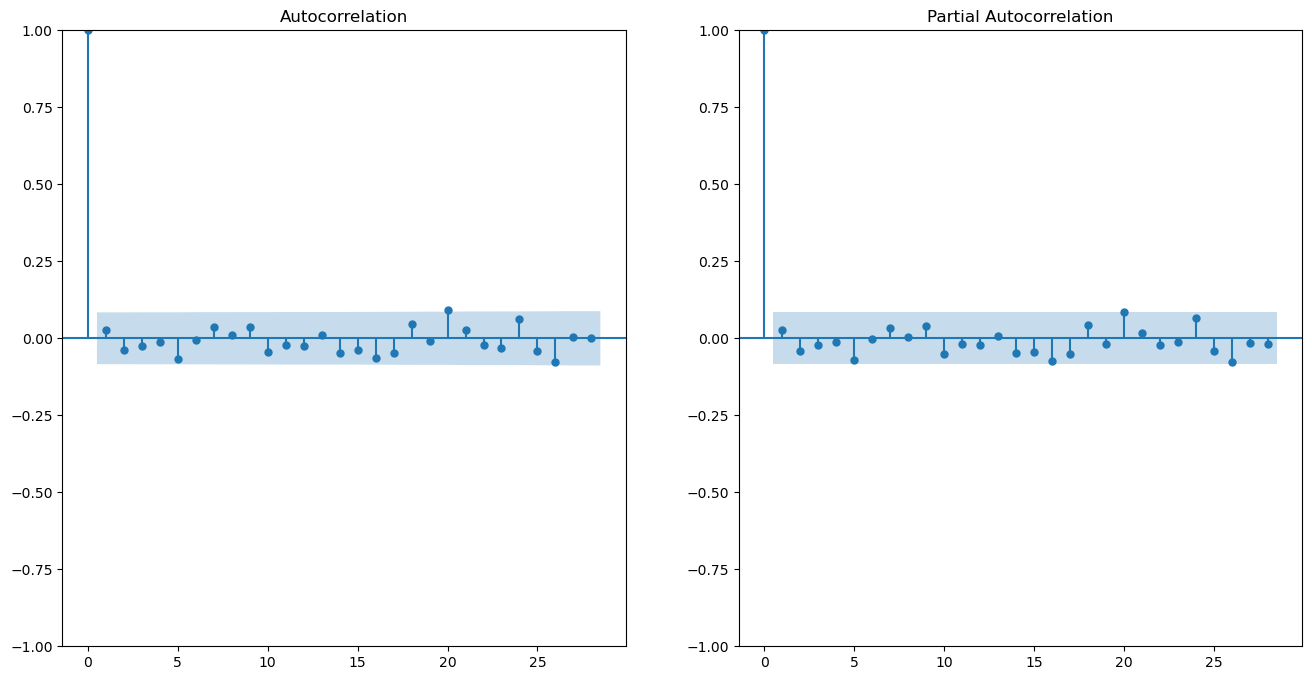

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_acf(us_train["Close_log_diff"], ax=ax1)
plot_pacf(us_train["Close_log_diff"], method="ywm", ax=ax2,)
plt.show()

# if the data is in the blue regioin that means it's no longer statistically significant for the next forecast
# lagged value or order = 20 for both AR and MA

# Statistical Modeling or Forecasting
ARIMA model with Residual plot. Additionally, volatility was modeled using GARCH to find correlation and predicted future return.

#### ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(us_train["Close_log"], order=(20,1,20)) # Already applied differencing for us with I = 1 
model_fit = model.fit()
print(model_fit.summary())

# Lower AIC via higher log likelihood or less parameter (more simple) -> Model that fit the value well and have less parameter
# Lower BIC vis less samples used in fitting

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

                               SARIMAX Results                                
Dep. Variable:              Close_log   No. Observations:                  542
Model:               ARIMA(20, 1, 20)   Log Likelihood                1842.338
Date:                Sun, 20 Apr 2025   AIC                          -3602.676
Time:                        23:34:41   BIC                          -3426.646
Sample:                             0   HQIC                         -3533.836
                                - 542                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0240      2.142      0.011      0.991      -4.175       4.223
ar.L2         -0.0315      2.021     -0.016      0.988      -3.992       3.929
ar.L3         -0.0085      1.793     -0.005      0.9

#### Residuals Plot

<Axes: title={'center': 'Density'}, ylabel='Density'>

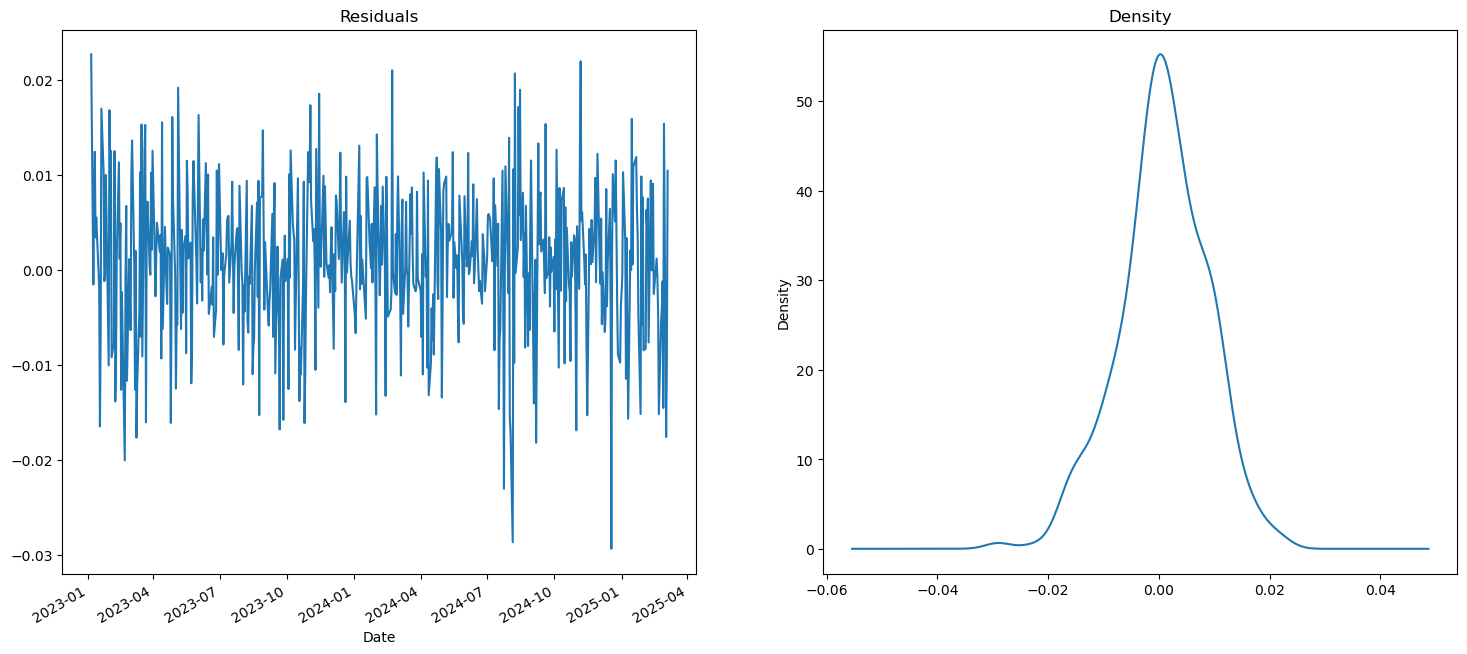

In [26]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])

# if the Model is good the residuals should looks like noise 
# The Residuals look random in general and the density look normal distribution like
# Can also looks ACF and PACF of the residuals

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


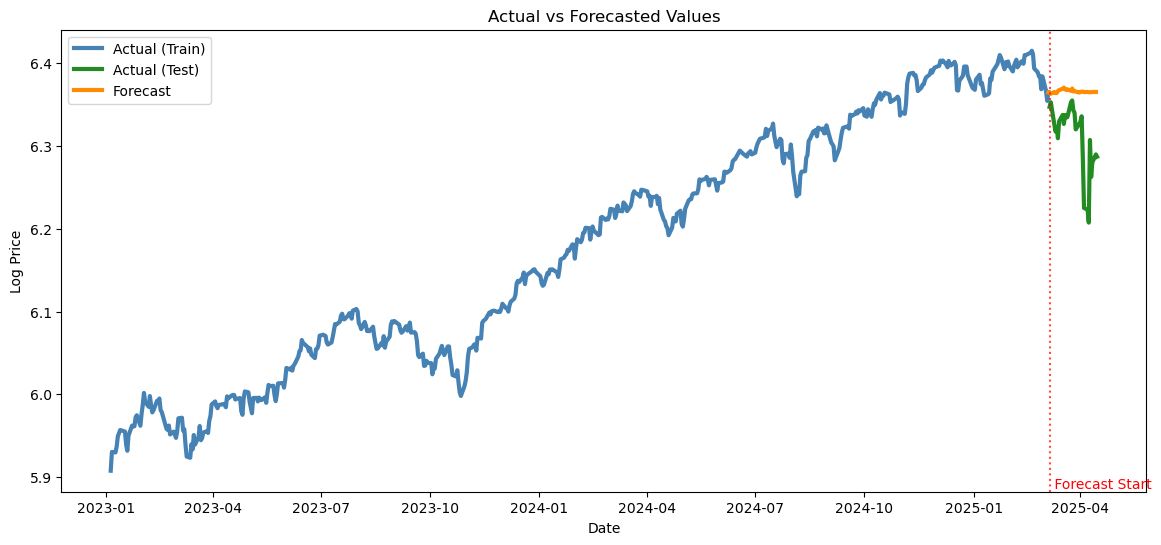

In [27]:
# forecast the test set
forecast_test = model_fit.forecast(len(us_test))

full_index = us.index[:len(us_train) + len(forecast_test)]

forecast_series = pd.Series([None]*len(us_train) + list(forecast_test), index=full_index)

# plotting train & test data
plt.figure(figsize=(14, 6))
plt.plot(us_train.index, us_train["Close_log"], label="Actual (Train)", color='steelblue', linewidth=3)

plt.plot(us_test.index, us_test["Close_log"], label="Actual (Test)", color='forestgreen', linewidth=3)
plt.plot(forecast_series.index, forecast_series, label="Forecast",  color='darkorange', linewidth=3)

forecast_start = us_test.index[0]
plt.axvline(x=forecast_start, color='red', linestyle=':', alpha=0.7)
plt.text(forecast_start, plt.ylim()[0], ' Forecast Start', color='red', verticalalignment='bottom')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.show()

# Doesn't look good. I try autofitting the arima model with pmdarima and got a model of ARIMA(0,1,0) which is just a horizontal line.
# Personally think that using ARIMA doesn't capture how much volatile the market is and fail to capture the real price

### SARIMA 
include the seasonal trend 

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# I was trying different order of p and q but it was mostly the same outcome
model_seasonal = ARIMA(us_train["Close_log"], order=(0,1,0), seasonal_order=(1, 1, 1, 5)) # Judging by the graph by can looks at PACF or ACF
model_seasonal_fit = model_seasonal.fit()
print(model_fit.summary())

# The AIC/BIC got a little bit smaller -> slightly better model 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Close_log   No. Observations:                  542
Model:               ARIMA(20, 1, 20)   Log Likelihood                1842.338
Date:                Sun, 20 Apr 2025   AIC                          -3602.676
Time:                        23:34:42   BIC                          -3426.646
Sample:                             0   HQIC                         -3533.836
                                - 542                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0240      2.142      0.011      0.991      -4.175       4.223
ar.L2         -0.0315      2.021     -0.016      0.988      -3.992       3.929
ar.L3         -0.0085      1.793     -0.005      0.9

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


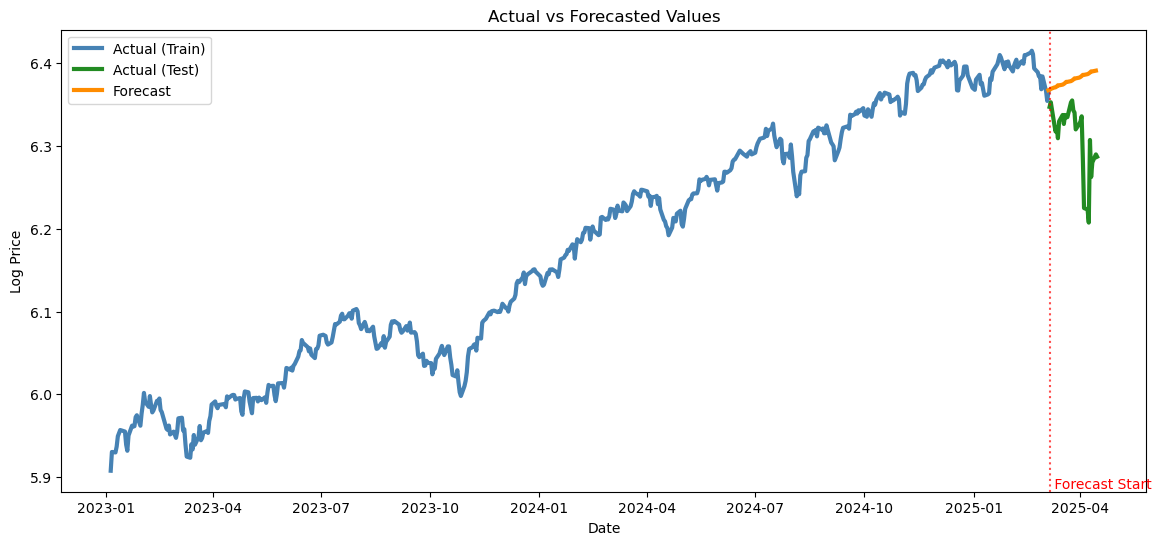

In [30]:
# Same process as ARIMA 
forecast_seasonal_test = model_seasonal_fit.forecast(len(us_test))

full_index = us.index[:len(us_train) + len(forecast_seasonal_test)]

forecast_seasonal_series = pd.Series([None]*len(us_train) + list(forecast_seasonal_test),index=full_index)

plt.figure(figsize=(14, 6))
plt.plot(us_train.index, us_train["Close_log"], label="Actual (Train)", color='steelblue', linewidth=3)

plt.plot(us_test.index, us_test["Close_log"], label="Actual (Test)", color='forestgreen', linewidth=3)
plt.plot(forecast_seasonal_series.index, forecast_seasonal_series, label="Forecast",  color='darkorange', linewidth=3)

forecast_start = us_test.index[0]
plt.axvline(x=forecast_start, color='red', linestyle=':', alpha=0.7)
plt.text(forecast_start, plt.ylim()[0], ' Forecast Start', color='red', verticalalignment='bottom')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.show()

# Still not a good forecast at all. Failed to capture how much volatile it would be at the start because of Trump's inauguration and Tariffs.

### Model Performance
Use mean absolute error, mean absolute percentage error, and mean square error to evaluate model performance. Comparing SARIMA with ARIMA

In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(us_test["Close_log"], forecast_test)
mape = mean_absolute_percentage_error(us_test["Close_log"], forecast_test)
rmse = np.sqrt(mean_squared_error(us_test["Close_log"], forecast_test))
print(mae, mape, rmse)

0.05407127909500895 0.008604678181105614 0.06639341111233532


In [33]:
mae = mean_absolute_error(us_test["Close_log"], forecast_seasonal_test)
mape = mean_absolute_percentage_error(us_test["Close_log"], forecast_seasonal_test)
rmse = np.sqrt(mean_squared_error(us_test["Close_log"], forecast_seasonal_test))
print(mae, mape, rmse)

0.0674318545361432 0.010726391507641094 0.08045238654340754


ARIMA has slightly lower errors than SARIMA, possibly due to the downward trend and increased volatility after 2025. While SARIMA accounts for seasonality and was forecasting an upward movement, the actual values dropped significantly, resulting in higher errors for SARIMA.

### GARCH
Comparing historical volatility with return percentages, and then forecasting volatility, in hopes of gaining insight from their past relationship. GARCH is a gerneralization from ARCH which is an Autoregresive model for conditional volatility. 

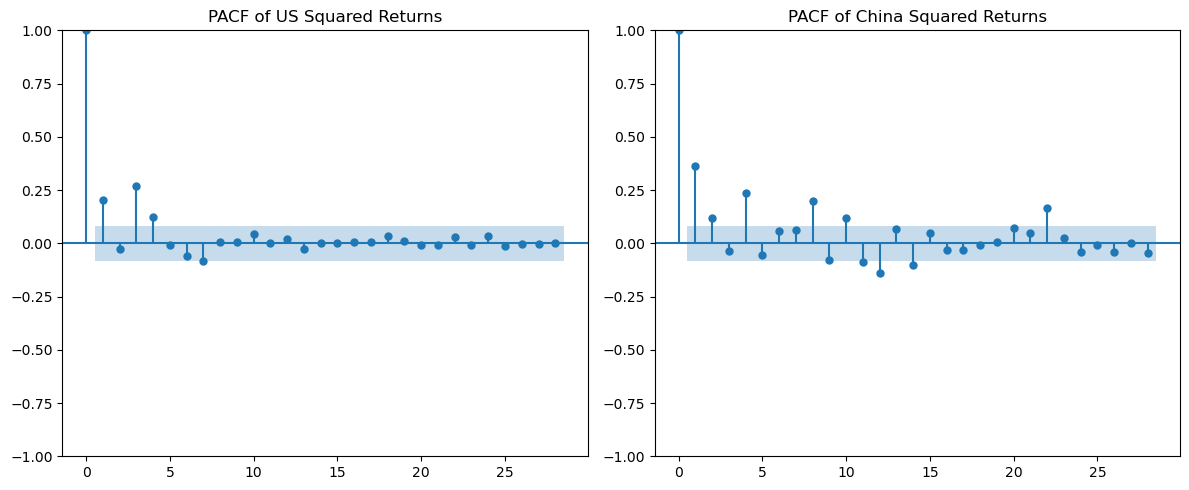

In [36]:
from arch import arch_model

# What lagged should we use? (Same as ARIMA since GARCH is just a Generalized AR with conditional volatility )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PACF for US variance 
plot_pacf(us["daily_return"]**2, ax=axes[0])
axes[0].set_title("PACF of US Squared Returns")

# PACF for China variance
plot_pacf(china["daily_return"]**2, ax=axes[1])
axes[1].set_title("PACF of China Squared Returns")

plt.tight_layout()
plt.show()
# US: Strong up until lagged 3 -> GARCH(3,3)
# China: Strong up until lagged 2 -> GARCH(2,2) 

### Fitting the right GARCH model

In [38]:
us_garch_model = arch_model(us["daily_return"], p=3, q=3)
us_garch_model_fit = us_garch_model.fit(disp="off") # I don't want to print the optimization details. Already too much text
us_garch_model_fit.summary()
# none of the betas are strong for this model (P-values are much more higher than 0) 
# We can drop them and still be statistically be confident with our model

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -727.517
Distribution:                  Normal   AIC:                           1471.03
Method:            Maximum Likelihood   BIC:                           1505.83
                                        No. Observations:                  572
Date:                Sun, Apr 20 2025   Df Residuals:                      571
Time:                        23:34:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0934  3.572e-02      2.616  8.896e-03 [2.343e-02,  0.163]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0729  9.698e-02      0.752      0.452    [ -0.117,  0.263]
alpha[1]       0.0685  7.319e-02      0.935      0.350 [-7.499e-02,  0.212]
alpha[2]       0.0000      0.249      0.000      1.000    [ -0.488,  0.488]
alpha[3]       0.1245      0.201      0.619      0.536    [ -0.270,  0.519]
beta[1]        0.7351      1.669      0.440      0.660    [ -2.536,  4.006]
beta[2]    4.9022e-14      2.314  2.119e-14      1.000    [ -4.535,  4.535]
beta[3]    1.7297e-14      1.719  1.006e-14      1.000    [ -3.369,  3.369]
===========================================================================

Covariance estimator: robust
"""

In [39]:
china_garch_model = arch_model(china["daily_return"], p=2, q=2)
china_garch_model_fit = china_garch_model.fit(disp="off")
china_garch_model_fit.summary() 

# Same as US. We can drop all betas since it's not statistically matter.

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -990.349
Distribution:                  Normal   AIC:                           1992.70
Method:            Maximum Likelihood   BIC:                           2018.79
                                        No. Observations:                  572
Date:                Sun, Apr 20 2025   Df Residuals:                      571
Time:                        23:34:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0182  4.853e-02     -0.374      0.708 [ -0.113,7.694e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6289      0.683      0.921      0.357   [ -0.709,  1.967]
alpha[1]       0.2157  9.808e-02      2.199  2.787e-02 [2.345e-02,  0.408]
alpha[2]       0.0263      0.233      0.113      0.910   [ -0.430,  0.482]
beta[1]        0.4620      1.527      0.303      0.762   [ -2.531,  3.455]
beta[2]        0.0000      0.929      0.000      1.000   [ -1.822,  1.822]
==========================================================================

Covariance estimator: robust
"""

### Trying out different Model
Drop all the betas (ie. q=0)

In [41]:
us_garch_model = arch_model(us["daily_return"], p=3, q=0)
us_garch_model_fit = us_garch_model.fit(disp="off")
us_garch_model_fit.summary()
# Now, it's look better

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -742.167
Distribution:                  Normal   AIC:                           1494.33
Method:            Maximum Likelihood   BIC:                           1516.08
                                        No. Observations:                  572
Date:                Sun, Apr 20 2025   Df Residuals:                      571
Time:                        23:34:43   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0651  3.868e-02      1.682  9.256e-02 [-1.075e-02,  0.141]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5436  9.633e-02      5.643  1.673e-08    [  0.355,  0.732]
alpha[1]       0.1098  5.610e-02      1.957  5.036e-02 [-1.739e-04,  0.220]
alpha[2]       0.0499  6.544e-02      0.763      0.445 [-7.831e-02,  0.178]
alpha[3]       0.1980  8.229e-02      2.406  1.615e-02  [3.667e-02,  0.359]
===========================================================================

Covariance estimator: robust
"""

In [42]:
china_garch_model = arch_model(china["daily_return"], p=2, q=0)
china_garch_model_fit = china_garch_model.fit(disp="off")
china_garch_model_fit.summary() 
# Looks better same as the US

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -993.558
Distribution:                  Normal   AIC:                           1995.12
Method:            Maximum Likelihood   BIC:                           2012.51
                                        No. Observations:                  572
Date:                Sun, Apr 20 2025   Df Residuals:                      571
Time:                        23:34:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0214  4.972e-02     -0.431      0.667 [ -0.119,7.602e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.2875      0.213      6.031  1.629e-09   [  0.869,  1.706]
alpha[1]       0.2798  9.302e-02      3.009  2.624e-03 [9.754e-02,  0.462]
alpha[2]       0.1324  4.773e-02      2.773  5.550e-03 [3.882e-02,  0.226]
==========================================================================

Covariance estimator: robust
"""

### GARCH Predictions

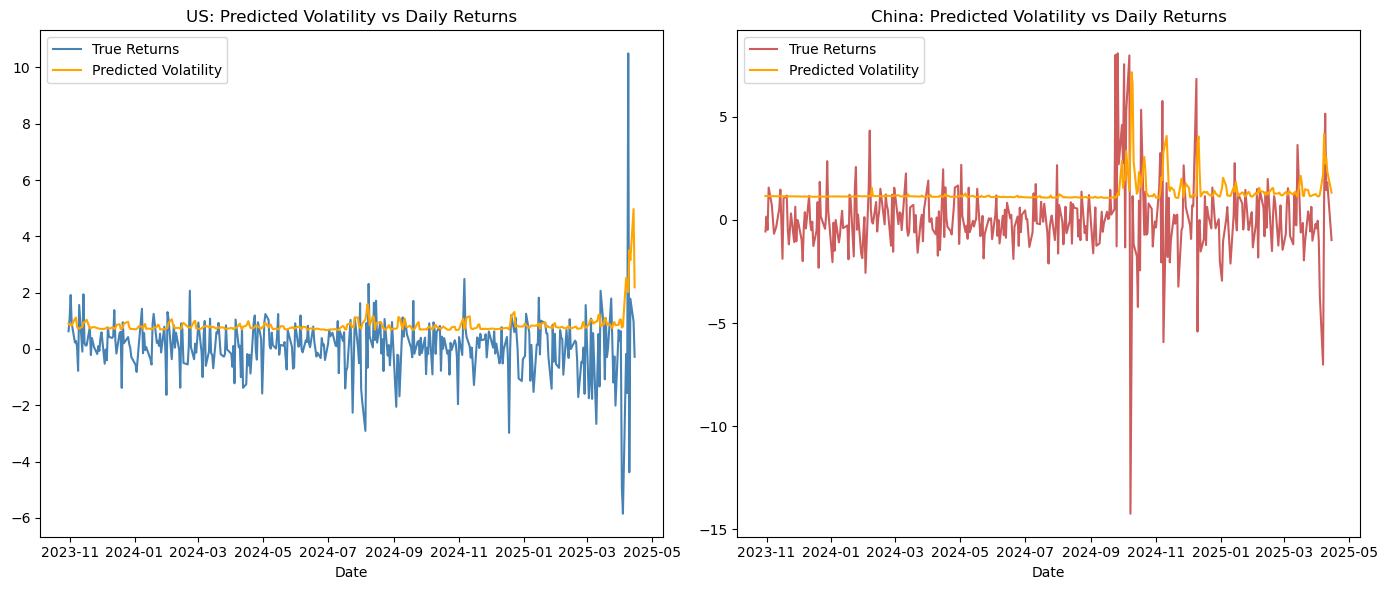

In [44]:
us_rolling_predictions = []
china_rolling_predictions = []
test_size = 365

# train model forecasting each data with horizon 1 in the future then append to our prediction list
def garch_predict(rolling_predictions, test_size, p, q, df):
    for i in range(test_size):
        train = df[:-(test_size-i)] # train up until the start of the 1-year period then keep inserting more data from that
        model = arch_model(train, p=p, q=q)
        model_fit = model.fit(disp="off") # I don't want to print the display. Already too much text
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) # Volatility ~ sqrt(varinace)

# compute rolling predictions 
garch_predict(us_rolling_predictions, test_size, 3, 0, us["daily_return"])
garch_predict(china_rolling_predictions, test_size, 2, 0, china["daily_return"])

# making sure the index is the same 
us_rolling_series = pd.Series(us_rolling_predictions, index=us["daily_return"].index[-365:])
china_rolling_series = pd.Series(china_rolling_predictions, index=china["daily_return"].index[-365:])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(us["daily_return"][-365:], label="True Returns", color="steelblue")
axes[0].plot(us_rolling_series, label="Predicted Volatility", color="orange")
axes[0].set_title("US: Predicted Volatility vs Daily Returns")
axes[0].set_xlabel("Date")
axes[0].legend()

axes[1].plot(china["daily_return"][-365:], label="True Returns", color="indianred")
axes[1].plot(china_rolling_series, label="Predicted Volatility", color="orange")
axes[1].set_title("China: Predicted Volatility vs Daily Returns")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()

# Returns fluctuate in response to changes in volatility, and the predicted volatility closely matches the actual 
# movements of the return percentages.
# Now, we can predict the volatility during the start of 2025

#### Future Forecast
Forecasting future volatility for the next 7 days

Text(0.5, 0, 'Date')

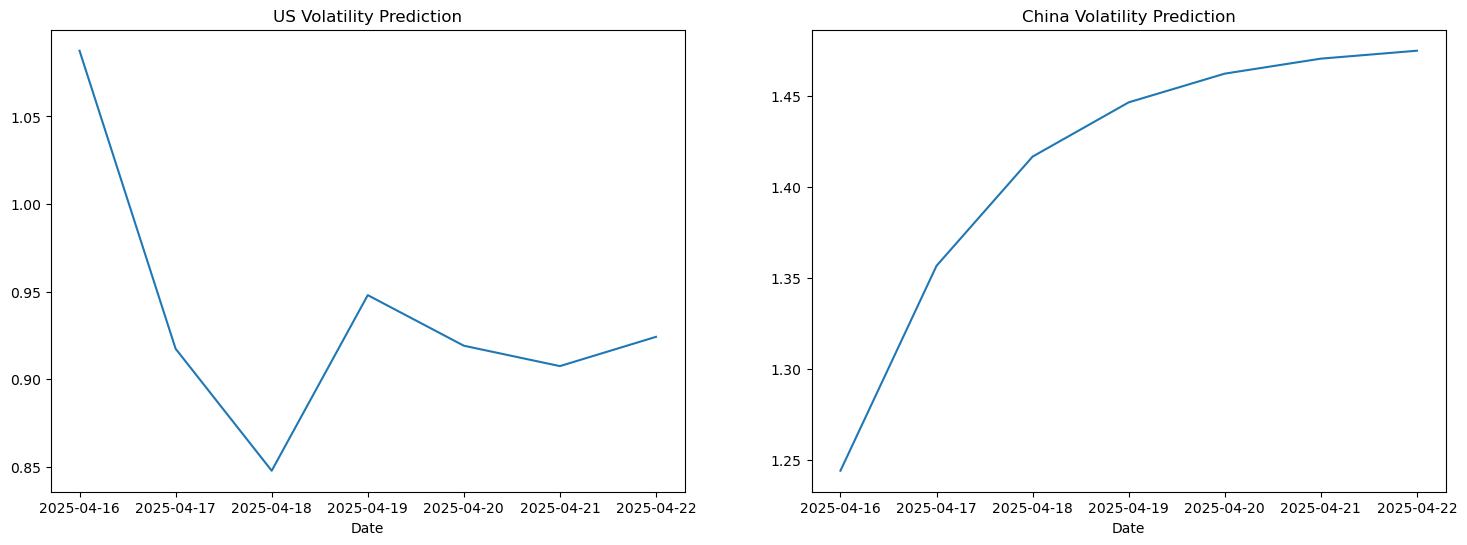

In [46]:
from datetime import datetime, timedelta

# same process but just forecast the next 7 days
us_pred = us_garch_model_fit.forecast(horizon=7) # next 7 days 
china_pred = china_garch_model_fit.forecast(horizon=7)
future_dates = [us["daily_return"].index[-1] + timedelta(days=i) for i in range(1,8)] # Same dates as china

us_pred = pd.Series(np.sqrt(us_pred.variance.values[-1,:]), index=future_dates)
china_pred = pd.Series(np.sqrt(china_pred.variance.values[-1,:]), index=future_dates)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(us_pred)
axes[0].set_title("US Volatility Prediction")
axes[0].set_xlabel("Date")

axes[1].plot(china_pred)
axes[1].set_title("China Volatility Prediction")
axes[1].set_xlabel("Date")

# the movement is somewhat opposite dring this period (2025 start of the trade war between China and US) 

# Insight Generation

From the ARIMA and SARIMA forecasts, it is evident that the models failed to capture the level of market volatility at the beginning of 2025. This period coincided with Trump's inauguration and the introduction of new tariff policies, both of which contributed to increased market uncertainty. The model was unable to account for these events and their impact on volatility. Similarly, if we accept the Efficient Market Hypothesis (EMH) as true, all available information is already priced into the market. That leaves only the random movements to predict.

After switching to a GARCH model, the predictions aligned much more closely with historical volatility compared to the raw returns. By extending the model to forecast future volatility, we observe a negative correlation between changes in volatility for China and the US. This relationship appears to hold accurately only during a specific time window, likely due to the trade tensions between the two countries. Outside of this context, applying the model to gain a consistent edge may be difficult, as the evidence for a strong or persistent correlation is limited.

#### Strategy based on Findings (guessing based on Quant Mentorship slides)

The strategy involves forecasting next-day volatility for US and China using GARCH(p, q), predicting the next-day log price level with ARIMA(p, 1, q), and analyzing cross-market correlation via PCA on a basket of closing prices. For improved performance, future implementations could use LSTM networks with cross-validation for a better price-level forecasting accuracy. Note: KPSS test is also something that should be look into